# Parsing Ideas:
**NOTE: this script for text extraction works only for reports from 2020 and later,** since documents from earlier years have different layouts. <br><br>

Different sections in the pdfs have very different layouts, which makes the text extraction rather challenging. For instance:
- Not everyone report the same information and this results in a different structure of the pdfs. For example, some employees report their investment activities while others not.
- Some sections in the pdf have horizontal orientation (e.g., general data, employment data), while some have vertical orientation (e.g.,curricular data). 
- Some sections have only one column (e.g., general data, working experience data), while some have multiple columns (e.g, investments data, immovable property data) or even mixed number of columns (employment data).
- Some sections have only one record (e.g. general data, employment data), while some might habe many records (e.g., working experience data, immovable/movable property data, vehicle data, investments and liability data)
  
Thus, it's not possible to extract all kinds of information with a uniform function and content-tailored text extraction strategies have to be developped. The parsing procedure is divided into 4 steps:

- Step 1: get the physical positions of subtitles and separate the original pdf into multiple subfiles based on these subtitles.<br>
- Step 2: from each subfile extract textual information by indentifying text elements that are possibly appearing on a same line (same column for curricular data) and save the results together with the document ID.<br>
- Step 3: merge the results of all subfiles on document ID to create a record of a single pdf in the database.
- Step 4: repeat the above steps for all pdfs and extend the database.

>  __Example: docuemnt ID = 20200520184715000415606729__ <br>
> - __Document Parsing__ 
> 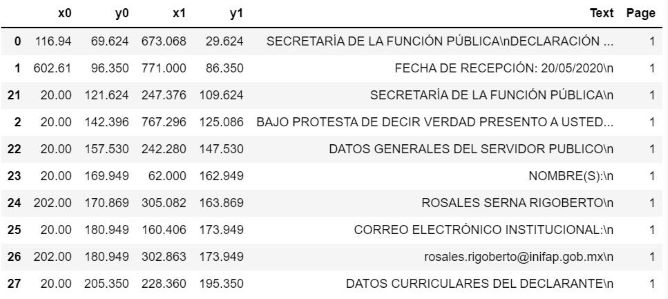
<br>
> - __Text Extraction Strategy__ <br>
>   e.g., searching key name "NOMBRE" returns the key-value pair: "NOMBRE(S):   ROSALES SERNA RIGOBERTO" <br>
> 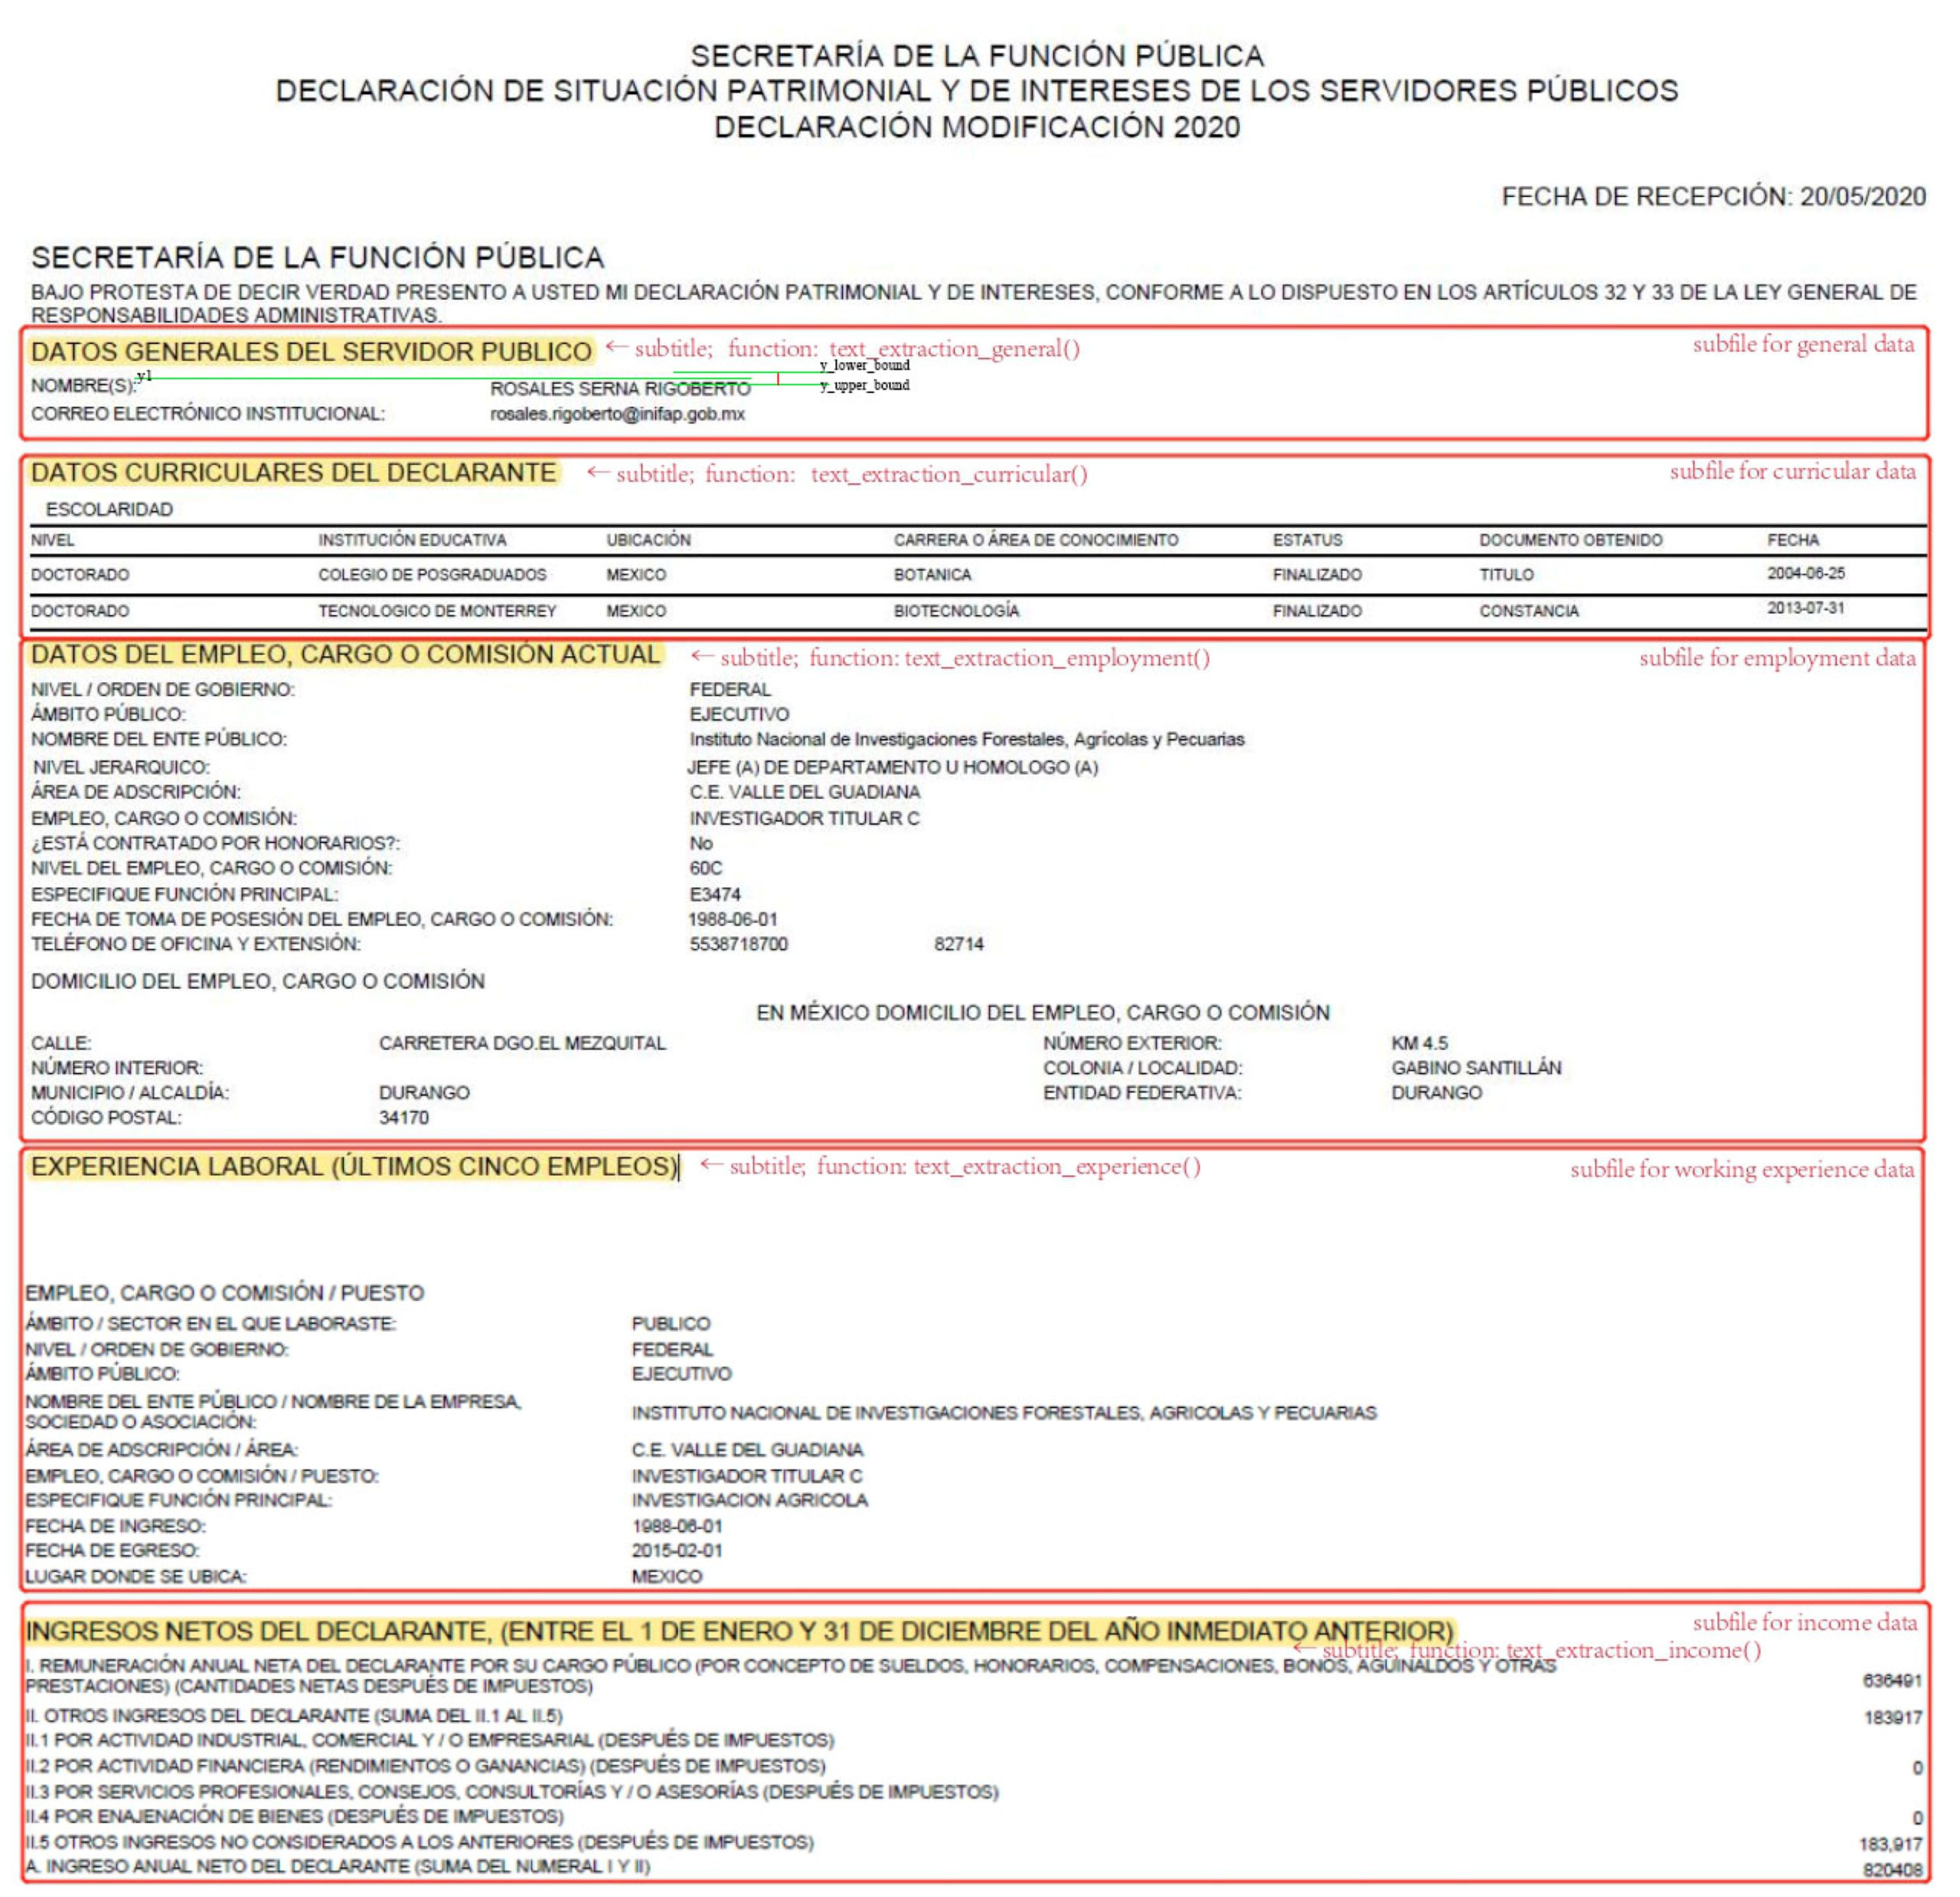
   

In [4]:
# import libraries
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfinterp import resolve1, PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import PDFPageAggregator, HTMLConverter, TextConverter
from pdfminer.layout import LAParams, LTTextBox,LTTextLine, LTFigure, LTImage, LTTextContainer
from pdfminer.pdfdocument import PDFDocument, PDFNoOutlines
from io import StringIO, BytesIO
import re
import pandas as pd
import numpy as np

The program is designed in a way to make its application as easy as possible. By design, the user just needs to first run the codes to define all functions required for text extraction, name lists of potential contents (Part 1 & Part 2), then read-in a starting csv file from the previous step which contains employee-document information, iterate over all pdfs and simply wait for a dataset to be produced (Part 3). <br>
<br>
The current parameters are set to achieve highest error tolerance. However, given that some pdfs might have weird layouts, the accuracy of extracted info cannot be guaranteed and in some cases the parameters may need to be re-set to fit specific documents better.<br>
 > **Lists of parameters:** 
- document_parser:  line_margin, char_margin, word_margin
- text_extraction_XX： margin values to build upper/lower bound of an element to increase error tolerance (e.g., ±5)

Regular Expressions(re) are introduced to tackle with minor differences in subtitle names and variable names, e.g., 'NIVEL JER[AÁ]RQUICO'. This part can be further improved to increase text extraction accuracy.

## Part 1: Functions
First the functions that might be used during texts extraction are defined. Based on their functionalities, these functions can be categorized into three groups: document preprocessing, texts extraction, and dataframe management.

### Group 1:  Functions for Document Preprocessing
<b>Document Parsing<b>

In [5]:
# define the function to intially parse the pdf
def document_parser(documentID):
    # read in the pdf
    document = open('Outcomes/3. pdf_collection/{}.pdf'.format(documentID), 'rb')

    # parse the pdf
    #  create resource manager
    rsrcmgr = PDFResourceManager()
    #  set parameters for analysis.
    laparams = LAParams(line_margin=0.2, char_margin=5, word_margin=1)    
    '''
        Parameters:
        line_margin: if two lines are are close together they are considered to be part of the same paragraph. 
        char_margin: if two characters are closer together than this margin they are considered part of the same line. 
        word_margin: if two characters on the same line are further apart than this margin they are considered to be 
                     two separate words, and an intermediate space will be added for readability.
    '''    
    #  create a PDF page aggregator object.
    device = PDFPageAggregator(rsrcmgr, laparams=laparams)
    interpreter = PDFPageInterpreter(rsrcmgr, device)

    data=[]
    page_num=1
    for page in PDFPage.get_pages(document):
        interpreter.process_page(page)
        mediabox=resolve1(page.attrs['MediaBox'])       # the physical size of the page.

        #  get the LTPage object for the page.
        layout = device.get_result()
        for element in layout:
            if isinstance(element, LTTextBox):
                x_0=element.bbox[0]                     # x0: coordinates of bottom left corner
                y_0=mediabox[2]-element.bbox[1]         # y0: coordinates of bottom left corner (from the top of the page)
                x_1=element.bbox[2]                     # x1: coordinates of upper right conner
                y_1=mediabox[2]-element.bbox[3]         # y1: coordinates of upper right conner (from the top of the page)
                text=element.get_text()
                page=page_num
                data.append([x_0,y_0,x_1,y_1,text,page])    
        page_num += 1
    
    # concatenate the pages (to virtually create a long page such that y0,y1 represent the distances from the top of page 1),
    #  so that elements appearing later have larger y0,y1.
    df=pd.DataFrame(data, columns=['x0','y0','x1','y1','Text','Page']).round(3)
    df['y0'] += (df['Page']-1) * mediabox[2]
    df['y1'] += (df['Page']-1) * mediabox[2]
    return df

<b>Subtitles Positioning<b>

In [6]:
# define the functions for locating an element(y1/x0) with regular expressions
def find_the_coordinates_with_re(df, string):
    for idx in range(len(df)):
        if re.match('{}.*'.format(string), df.iloc[idx,4].rstrip('\n')):
            y1 = df.iloc[idx,3]
            break
    return y1

def find_the_coordinates_with_re_x(df, string):
    for idx in range(len(df)):
        if re.match('{}.*'.format(string), df.iloc[idx,4].rstrip('\n')):
            x0 = df.iloc[idx,0]
            break
    return x0

# define the function to update the coordinates and create a list of titles found in the pdf
def create_title_list(df, candidate_titles_dict):
    title_list=[]
    for key,value in candidate_titles_dict.items():
        try:
            candidate_titles_dict[key][0] = find_the_coordinates_with_re(df, key)
            title_list.append(key)
        except:
            continue
    content_dict = {key: value for key,value in candidate_titles_dict.items() if key in title_list}
    return title_list,content_dict

<b>File Devision<b>

In [7]:
# def the function for file devision
def file_devision(df, title_list, content_dict):
    subfiles = {}
    for num in range(len(title_list)):
        if num < len(title_list)-1:
            y_top = content_dict[title_list[num]][0]
            y_bottom = content_dict[title_list[num+1]][0] 
            criterion = ((df['y1']>=y_top) & (df['y1']<y_bottom))
            subfiles[num] = df[criterion]
        else: 
            y_top = content_dict[title_list[num]][0]
            criterion = (df['y1']>=y_top)
            subfiles[num] = df[criterion]
    return subfiles


# define the function to find the right subfile
def find_the_right_subfile(subtitle, title_list, subfiles):
    for num in range(len(title_list)):
        for idx in range(len(subfiles[num])):
            if re.match('{}+'.format(subtitle), subfiles[num].iloc[idx,4]):
                return subfiles[num]

### Group 2: Functions for Textual Information Extraction

In [8]:
# general data
def text_extraction_general(df, content_list):
    df=df.sort_values(by=['y1','x0'], ascending=[True, True])
    
    for element in content_list:
        y = find_the_coordinates_with_re(df, element)
        y_lower_bound = y - 5      # the value of ±5 is added to increase error tolerance
        y_upper_bound = y + 5    
 
        items = df['Text'][(df['y1'] > y_lower_bound)&(df['y1'] < y_upper_bound)].tolist()
        for j in range(len(items)):
            items[j] = items[j].rstrip('\n').rstrip(':')
        if len(items) == 1:   
            text = (element, [np.NAN])  # missing value is set as NaN
        else:
            text = (items[0], [' '.join(items[1:])]) # multiple items are concatenated
        # add to dictionary
        dict_ID[text[0]] = text[1]

    # save as dataframe
    df_new = pd.DataFrame.from_dict(dict_ID)
    # add suffixes to variable names 
    df_new.columns=df_new.columns.map(lambda x : x+'_GENERAL' if x !='Document ID' else x)

    return df_new

In [9]:
# curricular data
def text_extraction_curricular(df, content_list):
    df=df.sort_values(by=['x0','y1'], ascending=[True, True])
    y1_title = df['y1'][df['Text']=='DATOS CURRICULARES DEL DECLARANTE\n'].values[0]
    
    for element in content_list:
        try:
            x = find_the_coordinates_with_re_x(df, element)
            x_lower_bound = x - 5      # the value of ±5 is added to increase error tolerance
            x_upper_bound = x + 5   
    
            items = df['Text'][(df['x0'] > x_lower_bound)&(df['x0'] < x_upper_bound)&(df['y1'] > y1_title)].tolist()

            for j in range(len(items)):
                items[j] = items[j].rstrip('\n')
            if len(items)==1:   
                text = (element, [np.NAN])  # missing value is set as NaN
            else:
                text = (items[0], items[1:]) # multiple items are concatenated
        except:
            text = (element, [np.NAN])
        # add to dictionary
        dict_ID[text[0]] = text[1]
    
    # save as dataframe
    df_new = pd.DataFrame()
    for key in dict_ID.keys():
        df_new = pd.concat([df_new, pd.DataFrame({key:dict_ID[key]})],axis=1)
    df_new['Document ID']=df_new['Document ID'].fillna(documentID)
    # reshape the dataframe
    df_new = long_to_wide(df_new, 'Document ID').reset_index(inplace=False)
    # add suffixes to variable names 
    df_new.columns=df_new.columns.map(lambda x : x+'_CURRICULAR' if x !='Document ID' else x)

    return df_new

In [10]:
# employment data
def text_extraction_employment(df, content_list):
    df=df.sort_values(by=['y1','x0'], ascending=[True, True])
    
    for i in range(0,3):   # 3: the length of the content_list for employment data
        for element in content_list[i]:
            try:
                y = find_the_coordinates_with_re(df, element)
                x = find_the_coordinates_with_re_x(df, element)
                y_lower_bound = y - 5      # the value of ±5 is added to increase error tolerance
                y_upper_bound = y + 5    
                # texts collection
                criterion = [(df['y1'] > y_lower_bound)&(df['y1'] < y_upper_bound),
                     # deal with two-column layout (corresponding to content_list[i])
                     (df['y1'] > y_lower_bound)&(df['y1'] < y_upper_bound)&(df['x0'] < 250),          # left column
                     (df['y1'] > y_lower_bound)&(df['y1'] < y_upper_bound)&(df['x0'] > 250)]          # right column
            
                items = df['Text'][criterion[i]].tolist()
                for j in range(len(items)):
                    items[j] = items[j].rstrip('\n').rstrip(':')
                # organize values
                if len(items)==1:   
                    text = (element, [np.NAN])  # missing value is set as NaN
                else:
                    text = (items[0], [' '.join(items[1:])]) # multiple values are concatenated
            except:
                text = (element, [np.NAN])
            # add to the dictionary
            dict_ID[text[0]] = text[1] 

    # save as dataframe
    df_new = pd.DataFrame()
    for key in dict_ID.keys():
        df_new = pd.concat([df_new, pd.DataFrame({key:dict_ID[key]})],axis=1)  
    df_new['Document ID']=df_new['Document ID'].fillna(documentID)
    # add suffixes to variable names 
    df_new.columns=df_new.columns.map(lambda x : x+'_EMPLOYMENT' if x !='Document ID' else x)

    return df_new

In [11]:
# working experience data
def text_extraction_experience(df, content_list):
    df=df.sort_values(by=['y1','x0'], ascending=[True, True])
    # get the number of past working experiences
    y_headers = df['y1'][df['Text'] == 'EMPLEO, CARGO O COMISIÓN / PUESTO\n'].tolist()  # first element of this part
    num_experience = len(y_headers)
    
    for i in range(num_experience):
        if i < num_experience-1:
            criterion = (df['y1'] > y_headers[i])&(df['y1'] < y_headers[i+1]) 
        elif i == num_experience-1:
            criterion = (df['y1'] > y_headers[i])
        contents = df[criterion]      
       # texts collection
        for element in content_list:
            try:
                y = find_the_coordinates_with_re(contents, element)
                y_lower_bound = y - 5      # the value of ±5 is added to increase error tolerance
                y_upper_bound = y + 5    
                
                items = contents['Text'][(contents['y1'] > y_lower_bound)&(contents['y1'] < y_upper_bound)].tolist()
                for j in range(len(items)):
                    items[j] = items[j].rstrip('\n').rstrip(':')
                # organize values
                if len(items)==1:   
                    text = (element, [np.NAN])  # missing value is set as NaN
                else:
                    text = (items[0], [' '.join(items[1:])]) # multiple values are concatenated
            except:
                text = (element, [np.NAN])
            # add into the dictionary  
            #  if the key already exists in the dictionary,append the value to the list; otherwise add the key-value pairs 
            if text[0] in dict_ID:
                dict_ID[text[0]] = dict_ID[text[0]] + text[1]
            else:
                dict_ID[text[0]] = text[1]
                
    # save as dataframe
    df_new = pd.DataFrame()
    for key in dict_ID.keys():
        df_new = pd.concat([df_new, pd.DataFrame({key:dict_ID[key]})],axis=1)
    df_new['Document ID']=df_new['Document ID'].fillna(documentID)
    # reshape the dataframe
    df_new = long_to_wide(df_new, 'Document ID').reset_index(inplace=False)
    # add suffixes to variable names 
    df_new.columns=df_new.columns.map(lambda x : x+'_EXPERIENCE' if x !='Document ID' else x)

    return df_new

In [12]:
# income data
def text_extraction_income(df, content_list):
    df=df.sort_values(by=['y1','x0'], ascending=[True, True])
    
    for element in content_list:
        try:
            y = find_the_coordinates_with_re(df, element)
            y_lower_bound = y - 8.5      # the value of ±8.5 is added to increase error tolerance
            y_upper_bound = y + 8.5 
            # get variable names
            variable_strings = df['Text'][(df['y1'] > y_lower_bound)&(df['y1'] < y_upper_bound)&(df['x0'] < 25)].tolist()
            variable = ''
            for v in variable_strings:
                variable += v.rstrip('\n')
            # get values
            value_strings = df['Text'][(df['y1'] > y_lower_bound)&(df['y1'] < y_upper_bound)&(df['x0'] > 400)].tolist()
            value = ''
            for v in value_strings:
                value += v.rstrip('\n')
            text = (variable, value) 
        except:
            text = (element, [np.NAN])
        # add to dictionary
        dict_ID[text[0]] = [text[1]]
 
    # save as dataframe
    df_new = pd.DataFrame()
    for key in dict_ID.keys():
        df_new = pd.concat([df_new, pd.DataFrame({key:dict_ID[key]})],axis=1)
    # add suffixes to variable names 
    df_new.columns=df_new.columns.map(lambda x : x+'_INCOME' if x !='Document ID' else x)

    return df_new

In [13]:
# immovable property data
def text_extraction_immovable_property(df, content_list):
    df=df.sort_values(by=['y1','x0'], ascending=[True, True])
    # get the number of records
    y_headers = df['y1'][df['Text'] == 'TIPO DE INMUEBLE:\n'].tolist()   # first element of this part
    num_re = len(y_headers)
    
    for num in range(num_re):
        if num < num_re-1:
            criterion = (df['y1'] > (y_headers[num]-3))&(df['y1'] < (y_headers[num+1]+3))  
        elif num == num_re-1:
            criterion = (df['y1'] > (y_headers[num]-3))      # ±3 is added to increase error tolerance
        contents = df[criterion]
        
        for i in range(0,3):   # 3: the length of the content_list for immovable data
            for element in content_list[i]:
                try:
                    y = find_the_coordinates_with_re(contents, element)
                    x = find_the_coordinates_with_re_x(contents, element)      
                    if element == 'PORCENTAJE DE PROPIEDAD DEL DECLARANTE':
                        y_lower_bound = y - 5
                        y_upper_bound = y + 25   
                    else:
                        y_lower_bound = y - 5
                        y_upper_bound = y + 12.5
                    # texts collection (deal with three-column layout) 
                    criterion = [(df['y1'] > y_lower_bound)&(df['y1'] < y_upper_bound)&(df['x0'] < 250),                 
                                 (df['y1'] > y_lower_bound)&(df['y1'] < y_upper_bound)&(df['x0'] > 250)&(df['x0']<500),  
                                 (df['y1'] > y_lower_bound)&(df['y1'] < y_upper_bound)&(df['x0'] > 500)]               
  
                    items = df['Text'][criterion[i]].tolist()
                    for j in range(len(items)):
                        items[j] = items[j].rstrip('\n').rstrip(':')
                    # organize the values
                    if len(items) == 1:   
                        text = (element, [np.NAN])  # missing value is set as NaN
                    else:
                        text = (items[0], [' '.join(items[1:])]) # multiple items are concatenated
                except:
                    text = (element, [np.NAN])
                # add to the dictionary
                #  if the key already exists in the dictionary,append the value to the list; otherwise add the key-value pairs 
                if text[0] in dict_ID:
                    dict_ID[text[0]] = dict_ID[text[0]] + text[1]
                else:
                    dict_ID[text[0]] = text[1]     
  
    # save as dataframe
    df_new = pd.DataFrame()
    for key in dict_ID.keys():
        df_new = pd.concat([df_new, pd.DataFrame({key:dict_ID[key]})],axis=1)  
    df_new['Document ID']=df_new['Document ID'].fillna(documentID)
    # reshape the dataframe
    df_new = long_to_wide(df_new, 'Document ID').reset_index(inplace=False)
    # add suffixes to variable names 
    df_new.columns=df_new.columns.map(lambda x : x+'_IMMOVABLE_PROPERTY' if x !='Document ID' else x)

    return df_new

In [14]:
# vehicle data
def text_extraction_vehicle(df, content_list):
    df=df.sort_values(by=['y1','x0'], ascending=[True, True])
    # get the number of records
    y_headers = df['y1'][df['Text'] == 'TIPO DE VEHÍCULO:\n'].tolist()  # first element of this part
    num_re = len(y_headers)
    
    for num in range(num_re):
        if num < num_re-1:
            criterion = (df['y1'] > (y_headers[num]-3))&(df['y1'] < (y_headers[num+1]+3))  
        elif num == num_re-1:
            criterion = (df['y1'] > (y_headers[num]-3))      # ±3 is added to increase error tolerance
        contents = df[criterion]
        
        for i in range(0,3):   # 3: the length of the content_list for vehicle data
            for element in content_list[i]:
                try:
                    y = find_the_coordinates_with_re(contents, element)
                    x = find_the_coordinates_with_re_x(contents, element)      
                    y_lower_bound = y - 5
                    y_upper_bound = y + 12.5
                    # texts collection (deal with three-column layout) 
                    criterion = [(df['y1'] > y_lower_bound)&(df['y1'] < y_upper_bound)&(df['x0'] < 250),                 
                                 (df['y1'] > y_lower_bound)&(df['y1'] < y_upper_bound)&(df['x0'] > 250)&(df['x0']<500),  
                                 (df['y1'] > y_lower_bound)&(df['y1'] < y_upper_bound)&(df['x0'] > 500)]               
 
                    items = df['Text'][criterion[i]].tolist()
                    for j in range(len(items)):
                        items[j] = items[j].rstrip('\n').rstrip(':')
                    # organize values
                    if len(items)==1:   
                        text = (element, [np.NAN])  # missing value is set as NaN
                    else:
                        text = (items[0], [' '.join(items[1:])]) # multiple items are concatenated
                except:
                    text = (element, [np.NAN])
                # add to the dictionary
                #  if the key already exists in the dictionary,append the value to the list; otherwise add the key-value pairs 
                if text[0] in dict_ID:
                    dict_ID[text[0]] = dict_ID[text[0]] + text[1]
                else:
                    dict_ID[text[0]] = text[1]     
  
    # save as dataframe
    df_new = pd.DataFrame()
    for key in dict_ID.keys():
        df_new = pd.concat([df_new, pd.DataFrame({key:dict_ID[key]})],axis=1)  
    df_new['Document ID']=df_new['Document ID'].fillna(documentID)
    # reshape the dataframe
    df_new = long_to_wide(df_new, 'Document ID').reset_index(inplace=False)
    # add suffixes to variable names 
    df_new.columns=df_new.columns.map(lambda x : x+'_VEHICLE' if x !='Document ID' else x)

    return df_new

In [15]:
# movable property data
def text_extraction_movable_property(df, content_list):
    df=df.sort_values(by=['y1','x0'], ascending=[True, True])
    # get the number of records
    y_headers = df['y1'][df['Text'] == 'TITULAR DEL BIEN:\n'].tolist()    # first element of this part
    num_re = len(y_headers)
    
    for num in range(num_re):
        if num < num_re-1:
            criterion = (df['y1'] > (y_headers[num]-3))&(df['y1'] < (y_headers[num+1]+3))  
        elif num == num_re-1:
            criterion = (df['y1'] > (y_headers[num]-3))      # ±3 is added to increase error tolerance
        contents = df[criterion]
        
        for i in range(0,3):   # 3: the length of the content_list for movable property data
            for element in content_list[i]:
                try:
                    y = find_the_coordinates_with_re(contents, element)
                    x = find_the_coordinates_with_re_x(contents, element)      
                    y_lower_bound = y - 5
                    y_upper_bound = y + 12.5
                    # texts collection (deal with three-column layout) 
                    criterion = [(df['y1'] > y_lower_bound)&(df['y1'] < y_upper_bound)&(df['x0'] < 250),                 
                                 (df['y1'] > y_lower_bound)&(df['y1'] < y_upper_bound)&(df['x0'] > 250)&(df['x0']<500),  
                                 (df['y1'] > y_lower_bound)&(df['y1'] < y_upper_bound)&(df['x0'] > 500)]               
 
                    items = df['Text'][criterion[i]].tolist()
                    for j in range(len(items)):
                        items[j] = items[j].rstrip('\n').rstrip(':')
                    # organize values
                    if len(items) == 1:
                        text = (element, [np.NAN])  # missing value is set as NaN
                    else:
                        text = (items[0], [' '.join(items[1:])]) # multiple items are concatenated
                except:
                    text = (element, [np.NAN])
                # add to the dictionary
                #  if the key already exists in the dictionary,append the value to the list; otherwise add the key-value pairs 
                if text[0] in dict_ID:
                    dict_ID[text[0]] = dict_ID[text[0]] + text[1]
                else:
                    dict_ID[text[0]] = text[1]     
  
    # save as dataframe
    df_new = pd.DataFrame()
    for key in dict_ID.keys():
        df_new = pd.concat([df_new, pd.DataFrame({key:dict_ID[key]})],axis=1)  
    df_new['Document ID']=df_new['Document ID'].fillna(documentID)
    # reshape the dataframe
    df_new = long_to_wide(df_new, 'Document ID').reset_index(inplace=False)
    # add suffixes to variable names 
    df_new.columns=df_new.columns.map(lambda x : x+'_MOVABLE_PROPERTY' if x !='Document ID' else x)

    return df_new

In [16]:
# investments data
def text_extraction_investments(df, content_list):
    df=df.sort_values(by=['y1','x0'], ascending=[True, True])
    # get the number of records
    y_headers = df['y1'][df['Text'] == 'TIPO DE INVERSIÓN / ACTIVO:\n'].tolist()    # first element in this part
    num_re = len(y_headers)
    
    for num in range(num_re):
        if num < num_re-1:
            criterion = (df['y1'] > (y_headers[num]-3))&(df['y1'] < (y_headers[num+1]+3))  
        elif num == num_re-1:
            criterion = (df['y1'] > (y_headers[num]-3))      # ±3 is added to increase error tolerance
        contents = df[criterion]
        
        for i in range(0,3):   # 3: the length of the content_list for investments data
            for element in content_list[i]:
                try:
                    y = find_the_coordinates_with_re(contents, element)
                    x = find_the_coordinates_with_re_x(contents, element)      
                    y_lower_bound = y - 5
                    y_upper_bound = y + 12.5
                    # texts collection (deal with three-column layout) 
                    criterion = [(df['y1'] > y_lower_bound)&(df['y1'] < y_upper_bound)&(df['x0'] < 250),                 
                                 (df['y1'] > y_lower_bound)&(df['y1'] < y_upper_bound)&(df['x0'] > 250)&(df['x0']<450),
                                 (df['y1'] > y_lower_bound)&(df['y1'] < y_upper_bound)&(df['x0'] > 450)]               
   
                    items = df['Text'][criterion[i]].tolist()
                    for j in range(len(items)):
                        items[j] = items[j].rstrip('\n').rstrip(':')
                    # organize values
                    if len(items) == 1:   
                        text = (element, [np.NAN])  # missing value is set as NaN
                    else:
                        text = (items[0], [' '.join(items[1:])]) # multiple items are concatenated
                except:
                    text = (element, [np.NAN])
                # add to the dictionary
                #  if the key already exists in the dictionary,append the value to the list; otherwise add the key-value pairs 
                if text[0] in dict_ID:
                    dict_ID[text[0]] = dict_ID[text[0]] + text[1]
                else:
                    dict_ID[text[0]] = text[1]     
  
    # save as dataframe
    df_new = pd.DataFrame()
    for key in dict_ID.keys():
        df_new = pd.concat([df_new, pd.DataFrame({key:dict_ID[key]})],axis=1)  
    df_new['Document ID']=df_new['Document ID'].fillna(documentID)
    # reshape the dataframe
    df_new = long_to_wide(df_new, 'Document ID').reset_index(inplace=False)
    # add suffixes to variable names 
    df_new.columns=df_new.columns.map(lambda x : x+'_INVESTMENTS' if x !='Document ID' else x)

    return df_new

In [17]:
# liability data
def text_extraction_liability(df, content_list):
    df=df.sort_values(by=['y1','x0'], ascending=[True, True])
    # get the number of records
    y_headers = df['y1'][df['Text'] == 'TITULAR DEL ADEUDO:\n'].tolist()    # first element in this part
    num_re = len(y_headers)
    
    for num in range(num_re):
        if num < num_re-1:
            criterion = (df['y1'] > (y_headers[num]-3))&(df['y1'] < (y_headers[num+1]+3))  
        elif num == num_re-1:
            criterion = (df['y1'] > (y_headers[num]-3))      # ±3 is added to increase error tolerance
        contents = df[criterion]
        
        for i in range(0,3):   # 3: the length of the content_list for liability data
            for element in content_list[i]:
                try:
                    y = find_the_coordinates_with_re(contents, element)
                    x = find_the_coordinates_with_re_x(contents, element)      
                    y_lower_bound = y - 5
                    y_upper_bound = y + 12.5
                    # texts collection (deal with three-column layout) 
                    criterion = [(df['y1'] > y_lower_bound)&(df['y1'] < y_upper_bound)&(df['x0'] < 250),                 
                                 (df['y1'] > y_lower_bound)&(df['y1'] < y_upper_bound)&(df['x0'] > 250)&(df['x0']<450),
                                 (df['y1'] > y_lower_bound)&(df['y1'] < y_upper_bound)&(df['x0'] > 450)]               
   
                    items = df['Text'][criterion[i]].tolist()
                    for j in range(len(items)):
                        items[j] = items[j].rstrip('\n').rstrip(':')
                    # organize values
                    if len(items) == 1:
                        text = (element, [np.NAN])   # missing value is set as NaN
                    else:
                        text = (items[0], [' '.join(items[1:])]) # multiple items are concatenated
                except:
                    text = (element, [np.NAN])
                # add to the dictionary
                #  if the key already exists in the dictionary,append the value to the list; otherwise add the key-value pairs 
                if text[0] in dict_ID:
                    dict_ID[text[0]] = dict_ID[text[0]] + text[1]
                else:
                    dict_ID[text[0]] = text[1]     
  
    # save as dataframe
    df_new = pd.DataFrame()
    for key in dict_ID.keys():
        df_new = pd.concat([df_new, pd.DataFrame({key:dict_ID[key]})],axis=1)  
    df_new['Document ID']=df_new['Document ID'].fillna(documentID)
    # reshape the dataframe
    df_new = long_to_wide(df_new, 'Document ID').reset_index(inplace=False)
    # add suffixes to variable names 
    df_new.columns=df_new.columns.map(lambda x : x+'_LIABILITY' if x !='Document ID' else x)

    return df_new

### Group 3: Functions for Dataframe Management

In [18]:
# define the fuction to convert the dataframe from long to wide format so that now each line in the 
#  dataset is corresponding to a single pdf
def long_to_wide(df, idx_var):
    df1 = df.set_index([idx_var, df.groupby(idx_var).cumcount().add(1).astype(str)]).unstack()
    df1.columns = df1.columns.map('_'.join)
    return df1

## Part 2: Contents in PDF Files

These content lists are summarized according to a pdf with richest information by far. In case further information is discovered in the future, the content lists can be updated accordingly.

In [19]:
# general data
subtitle_general = 'DATOS GENERALES DEL SERVIDOR PUBLICO'
content_list_general = ['NOMBRE', 'CORREO ELECTRÓNICO INSTITUCIONAL']

# curricular data
subtitle_curricular = 'DATOS CURRICULARES DEL DECLARANTE'
content_list_curricular = ['NIVEL','INSTITUCIÓN','UBICACIÓN','CARRERA O ÁREA DE CONOCIMIENTO','ESTATUS',
                           'DOCUMENTO OBTENIDO','FECHA']

# employment data
subtitle_employment = 'DATOS DEL EMPLEO, CARGO O COMISIÓN'
content_list_employment = [['NIVEL / ORDEN DE GOBIERNO','ÁMBITO PÚBLICO','NOMBRE DEL ENTE PÚBLICO','NIVEL JER[AÁ]RQUICO',
                            'ÁREA DE ADSCRIPCIÓN','EMPLEO, CARGO O COMISIÓN:', 
                            '¿ESTÁ CONTRATADO.* POR HONORARIOS?',   # regular expression is used to deal with different variable names
                            'NIVEL DEL EMPLEO, CARGO O COMISIÓN','ESPECIFIQUE FUNCIÓN PRINCIPAL','FECHA','TELÉFONO'],
                          ['NÚMERO INTERIOR', 'CALLE', 'MUNICIPIO','CÓDIGO POSTAL'],
                          ['NÚMERO EXTERIOR', 'COLONIA / LOCALIDAD','ENTIDAD FEDERATIVA']]

# working experience data
subtitle_experience = 'EXPERIENCIA LABORAL'
content_list_experience = ['ÁMBITO / SECTOR EN EL QUE LABORASTE','NIVEL / ORDEN DE GOBIERNO', 'ÁMBITO PÚBLICO',
                           'NOMBRE DEL ENTE PÚBLICO / NOMBRE DE LA EMPRESA','RFC', 'SECTOR AL QUE PERTENECE',
                           'ÁREA','EMPLEO, CARGO O COMISIÓN / PUESTO:', 'ESPECIFIQUE FUNCIÓN PRINCIPAL', 
                           'FECHA DE INGRESO', 'FECHA DE EGRESO','LUGAR DONDE SE UBICA']

# income data
subtitle_income = 'INGRESOS NETOS DEL DECLARANTE'
content_list_income = ['I. REMUNERACIÓN ANUAL',
                       'II. OTROS INGRESOS DEL DECLARANTE',
                       'II.1 POR ACTIVIDAD INDUSTRIAL, COMERCIAL',
                       'II.2 POR ACTIVIDAD FINANCIERA',
                       'II.3 POR SERVICIOS PROFESIONALES, CONSEJOS',
                       'II.4 POR ENAJENACIÓN DE BIENES',
                       'II.5 OTROS INGRESOS NO CONSIDERADOS A LOS',
                       'A. INGRESO ANUAL NETO DEL DECLARANTE']

# immovable property data
subtitle_immovable_property = 'BIENES INMUEBLES'
content_list_immovable_property = [['TIPO DE INMUEBLE','SUPERFICIE DEL TERRENO','TRANSMISOR','FORMA DE ADQUISICIÓN',
                                    'TIPO DE MONEDA','¿EL VALOR DE ADQUISICIÓN DEL INMUEBLE ES CONFORME A?',
                                    'EN CASO DE BAJA DEL INMUEBLE INCLUIR MOTIVO'],
                                   ['TITULAR DEL INMUEBLE','SUPERFICIE DE CONSTRUCCIÓN','FORMA DE PAGO',
                                    'FECHA DE ADQUISICIÓN DEL INMUEBLE'],
                                   ['PORCENTAJE DE PROPIEDAD DEL DECLARANTE','VALOR DE ADQUISICIÓN']]

# vehicle data
subtitle_vehicle = 'VEHÍCULOS'
content_list_vehicle = [['TIPO DE VEHÍCULO','TRANSMISOR','MARCA','FORMA DE ADQUISICIÓN','TIPO DE MONEDA'],
                        ['TITULAR DEL VEHÍCULO','MODELO','FORMA DE PAGO','FECHA DE ADQUISICIÓN DEL VEHÍCULO'],
                        ['AÑO','VALOR DE ADQUISICIÓN DEL VEHÍCULO','EN CASO DE BAJA DEL VEHÍCULO INCLUIR MOTIVO']]

# movable property data
subtitle_movable_property = 'BIENES MUEBLES'
content_list_movable_property = [['TITULAR DEL BIEN','TRANSMISOR','DESCRIPCION GENERAL DEL BIEN','TIPO DE MONEDA',
                                  'EN CASO DE BAJA DEL MUEBLE INCLUIR MOTIVO'],
                                 ['TIPO DEL BIEN','FORMA DE ADQUISICIÓN','VALOR DE ADQUISICIÓN DEL MUEBLE'],
                                 ['NOMBRE O RAZÓN SOCIAL DEL TRANSMISOR DE LA PROPIEDAD','FORMA DE PAGO',
                                  'FECHA DE ADQUISICIÓN']]

# investments data
subtitle_investments = 'INVERSIONES, CUENTAS BANCARIAS Y OTRO TIPO DE VALORES / ACTIVOS'
content_list_investments = [['TIPO DE INVERSIÓN / ACTIVO','INSTITUCIÓN O RAZÓN SOCIAL'],
                            ['SUB TIPO DE INVERSIÓN','RFC','TIPO DE MONEDA'],
                            #'¿DÓNDE SE LOCALIZA LA INVERSIÓN, CUENTA BANCARIA Y OTRO TIPO DE VALORES / ACTIVOS ?',(not able to extract with current method)
                            ['TITULAR DE LA INVERSIÓN, CUENTA BANCARIA Y OTRO TIPO DE VALORES']]

# liability data
subtitle_liability = 'ADEUDOS / PASIVOS'
content_list_liability = [['TITULAR DEL ADEUDO','FECHA DE ADQUISICIÓN DEL ADEUDO / PASIVO',
                           'OTORGANTE DEL CRÉDITO','¿DÓNDE SE LOCALIZA EL ADEUDO?'],
                         ['TIPO DE ADEUDO','MONTO ORIGINAL DEL ADEUDO / PASIVO','Nombre'],
                         ['TIPO DE MONEDA']]

In [20]:
# initialize the y-coordinates
y_general,y_curricular,y_employment,y_experience,y_income,y_immovable_property,y_vehicle,y_movable_property,y_investments,y_liability,y_third_party = [0]*11

# create a dictionary of candidate subtitles 
#  (this dictionary contains info/tools required for extracting texts from the corresponding subfile)
candidate_titles_dict = {'DATOS GENERALES DEL SERVIDOR PUBLICO': [y_general, subtitle_general, content_list_general, text_extraction_general],
                         'DATOS CURRICULARES DEL DECLARANTE': [y_curricular, subtitle_curricular, content_list_curricular, text_extraction_curricular],
                         'DATOS DEL EMPLEO, CARGO O COMISIÓN': [y_employment, subtitle_employment, content_list_employment, text_extraction_employment],
                         'EXPERIENCIA LABORAL': [y_experience, subtitle_experience, content_list_experience, text_extraction_experience],
                         'INGRESOS NETOS DEL DECLARANTE': [y_income, subtitle_income, content_list_income, text_extraction_income],
                         'BIENES INMUEBLES': [y_immovable_property, subtitle_immovable_property, content_list_immovable_property, text_extraction_immovable_property],
                         'VEHÍCULOS': [y_vehicle, subtitle_vehicle, content_list_vehicle, text_extraction_vehicle],
                         'BIENES MUEBLES': [y_movable_property, subtitle_movable_property, content_list_movable_property, text_extraction_movable_property],
                         'INVERSIONES, CUENTAS BANCARIAS Y OTRO TIPO DE VALORES / ACTIVOS': [y_investments, subtitle_investments, content_list_investments, text_extraction_investments],
                         'ADEUDOS / PASIVOS': [y_liability, subtitle_liability, content_list_liability, text_extraction_liability]}

## Part 3： Iterate over Files

In [21]:
# read the csv file (from step3) which contains IndividualID and DocumentID 
df_pdf = pd.read_csv('Example_Input.csv').drop(columns=['Unnamed: 0'])    # specify the file name
display(df_pdf)

,Individual ID,Document ID
0,HELR920714U61,20210508133905001233954220
1,HELA7310306B0,20210507140840002469081324
2,LOHA6804306BA,20210521112759002947048728
3,LOHA7411116B6,20210513101414002305011158
4,LOHA7108086B5,20201230192825003422205793
5,LOHA7104156B3,20210508180847002057229255
6,LOHA7505066BA,20210520094251002759914411
7,LOHA9704256B9,20210126092343003430276348
8,HELA980802844,20210517222955002317050113
9,HELA760305TA0,20210512230635002202370762


In [23]:
# create a list to store final outputs of all pdf files
df_with_extractions_all = []

# iterate over all pdf files
for idx, row in df_pdf.iterrows():
    individualID = row[0]
    documentID = row[1] 
    # reset the y1-coordinates in the dictionary 
    for key in candidate_titles_dict.keys():
        candidate_titles_dict[key][0] = 0
        
    '''
    process single pdf file
    '''
    #  open and parse the pdf file with file name 'documentID'
    df = document_parser(documentID).sort_values(by=['y1'],ascending=True)
    #  divide the pdf into subfiles based on the contents
    title_list = create_title_list(df, candidate_titles_dict)[0]
    content_dict = create_title_list(df, candidate_titles_dict)[1]
    subfiles = file_devision(df, title_list, content_dict)
    #  create a list to save intermediate results of each subfile
    df_with_extractions_single = []
    #  iterate over all subfiles
    for key in content_dict.keys():
        dict_ID = {'Document ID': [documentID]}
        # prepare for texts extraction
        subtitle = content_dict[key][1]
        content_list = content_dict[key][2]
        extraction_function = content_dict[key][3]
        # find the right subfile corresponding to the key and save the texts from this subfile in a temprary dataframe
        df_temp = find_the_right_subfile(subtitle, title_list, subfiles)
        df_temp_new = extraction_function(df_temp, content_list)
        # add the temperary dataframe into the list
        df_with_extractions_single.append(df_temp_new)      
    #  merge the temporary dataframes in the list to get the final output for this single pdf
    df_final_single = pd.DataFrame({'Indivdual ID': [individualID], 'Document ID':[documentID]})
    for f in df_with_extractions_single:
        df_final_single = df_final_single.merge(f, on='Document ID') 
    #  add the final result dataframe of a single pdf to the final list
    df_with_extractions_all.append(df_final_single)

    
# concatenate dataframes in the final list (if a column is not in the dataframe, the cell is set as NaN)     
df_final_all = pd.concat(df_with_extractions_all, axis = 0, ignore_index=True)
df_final_all

,Indivdual ID,Document ID,NOMBRE(S)_GENERAL,CORREO ELECTRÓNICO INSTITUCIONAL_GENERAL,NIVEL_1_CURRICULAR,INSTITUCIÓN EDUCATIVA_1_CURRICULAR,UBICACIÓN_1_CURRICULAR,CARRERA O ÁREA DE CONOCIMIENTO_1_CURRICULAR,ESTATUS_1_CURRICULAR,DOCUMENTO OBTENIDO_1_CURRICULAR,...,ESPECIFIQUE FUNCIÓN PRINCIPAL_8_EXPERIENCE,FECHA DE INGRESO_6_EXPERIENCE,FECHA DE INGRESO_7_EXPERIENCE,FECHA DE INGRESO_8_EXPERIENCE,FECHA DE EGRESO_6_EXPERIENCE,FECHA DE EGRESO_7_EXPERIENCE,FECHA DE EGRESO_8_EXPERIENCE,LUGAR DONDE SE UBICA_6_EXPERIENCE,LUGAR DONDE SE UBICA_7_EXPERIENCE,LUGAR DONDE SE UBICA_8_EXPERIENCE
0,HELR920714U61,20210508133905001233954220,HERNANDEZ LOPEZ RODRIGO ADRIAN,NaN,BACHILLERATO,COBACH 7,MEXICO,TECNICO EN MANTENIMIENTO DE CIRCUITOS FINALIZADO,NaN,CERTIFICADO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HELA7310306B0,20210507140840002469081324,HERNANDEZ LOPEZ ADRIANA,ahernandezl@liconsa.gob.mx,CARRERA TECNICA O COMERCIAL,CENTRO DE ESTUDIOS DE\nCOMPUTACION CUERNAVACA ...,MEXICO,PROGRAMADOR ANALISTA,FINALIZADO,CERTIFICADO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LOHA6804306BA,20210521112759002947048728,LOPEZ HERNANDEZ ADRIANA,adriana.lopezhe@imss.gob.mx,LICENCIATURA,UNIVERSIDAD AUTONOMA DE\nSINALOA,MEXICO,TRABAJO SOCIAL,FINALIZADO,TITULO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LOHA7411116B6,20210513101414002305011158,LOPEZ HERNANDEZ ADRIANA,NaN,LICENCIATURA,UNAM,MEXICO,PSICOLOGIA,FINALIZADO,TITULO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LOHA7108086B5,20201230192825003422205793,LOPEZ HERNANDEZ ADRIANA,NaN,CARRERA TECNICA O COMERCIAL,CONALEP,MEXICO,TECNICO PROFESIONAL ASISTENTE EJECUTIVO FINALI...,NaN,TITULO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,LOHA7104156B3,20210508180847002057229255,LOPEZ LOPEZ ADRIANA,adriana.lopez@docente.dgcft.sems.gob.mx,LICENCIATURA,UNIVERSIDAD ABIERTA Y A DISTANCIA\nDE MÉXICO,MEXICO,ADMINISTRACIÓN Y GESTIÓN PÚBLICA,FINALIZADO,TITULO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,LOHA7505066BA,20210520094251002759914411,LOPEZ HERNANDEZ ADRIANA,NaN,SECUNDARIA,FEDERAL 4,MEXICO,CONOCIMIENTO BASICO,FINALIZADO,CERTIFICADO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,LOHA9704256B9,20210126092343003430276348,LÓPEZ HERNÁNDEZ ADRIANA,NaN,LICENCIATURA,ESCUELA NACIONAL DE ENFERMERIA\nY OBSTETRICIA,MEXICO,LICENCIATURA DE ENFERMERIA Y OBSTETRICIA CURSANDO,NaN,CONSTANCIA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,HELA980802844,20210517222955002317050113,HERNANDEZ LOPEZ ADRIANA ALEJANDRA,NaN,BACHILLERATO,CENEVAL,MEXICO,COMPUTACION,FINALIZADO,CERTIFICADO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,HELA760305TA0,20210512230635002202370762,HERNANDEZ LOPEZ ADRIANA ELIZABETH,NaN,LICENCIATURA,ESCUELA NACIONAL DE ENFERMERIA\nY OBSTETRICIA ...,MEXICO,LICENCIADA EN ENFERMERIA Y OBSTETRICIA FINALIZADO,NaN,TITULO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# export the final dataframe as csv file
df_final_all.to_csv('Outcomes/4. text_extraction/output_1.csv')